In [1]:
%cd ../..

# ego = Car on drivableRoad,
#         facing Range(-15, 15) deg relative to roadDirection,
#         with visibleDistance 50,
#         with viewAngle 135 deg

# other1 = Car on intersection,
#             facing Range(50, 135) deg relative to ego.heading

# other2 = Car on intersection,
#             facing -1 * Range(50, 135) deg relative to ego.heading

# require abs(relative heading of other1 from other2) > 100 deg
# require (distance from ego to intersectionRegion) < 10

/home/eecs/chanwutk/Documents/apperception


In [2]:
import time
from os import environ

In [3]:
if environ["AP_PORT"] is None:
    environ["AP_PORT"] = str(input('port'))

In [5]:
from apperception.database import database
from apperception.world import empty_world
from apperception.utils import F
from apperception.predicate import camera, objects, lit
database.connection

<connection object at 0x7fe1a5cb07c0; dsn: 'user=docker password=xxx dbname=mobilitydb host=localhost port=25442', closed: 0>

In [6]:
name = 'ScenicWorld' # world name
world = empty_world(name=name)

obj1 = objects[0]
obj2 = objects[1]
cam = camera

world = world.filter(
    (obj1.id != obj2.id) &
    F.like(obj1.type, 'vehicle%') &
    F.like(obj2.type, 'vehicle%') &
    F.angle_between(F.facing_relative(cam.ego, F.road_direction(cam.ego, cam.ego)), -15, 15) &
    (F.distance(cam.ego, obj1@cam.time) < 50) &
    (F.view_angle(obj1.traj@cam.time, cam.ego) < 70 / 2.0) &
    (F.distance(cam.ego, obj2@cam.time) < 50) &
    (F.view_angle(obj2.traj@cam.time, cam.ego) < 70 / 2.0) &
    F.contains_all('intersection', [obj1.traj, obj2.traj]@cam.time) &
    F.angle_between(F.facing_relative(obj1.traj@cam.time, cam.ego), 50, 135) &
    F.angle_between(F.facing_relative(obj2.traj@cam.time, cam.ego), -135, -50) &
    (F.min_distance(cam.cam, F.road_segment('intersection')) < 10) &
    F.angle_between(F.facing_relative(obj1.traj@cam.time, obj2.traj@cam.time), 100, -100)
)

# world = world.filter("lambda obj1, obj2, cam: " +
#     "obj1.object_id != obj2.object_id and " +
#     "F.like(obj1.object_type, 'vehicle%') and " +
#     "F.like(obj2.object_type, 'vehicle%') and " +
#     "F.angle_between(F.facing_relative(cam.ego, F.road_direction(cam.ego, cam.ego)), -15, 15) and " +
#     "F.distance(cam.ego, obj1, cam.timestamp) < 50 and " +
#     "F.view_angle(obj1, cam.ego, cam.timestamp) < 70 / 2.0 and " +
#     "F.distance(cam.ego, obj2, cam.timestamp) < 50 and " +
#     "F.view_angle(obj2, cam.ego, cam.timestamp) < 70 / 2.0 and " +
#     "F.contains_all('intersection', [obj1.traj, obj2.traj]@cam.timestamp) and "
#     "F.angle_between(F.facing_relative(obj1, cam.ego, cam.timestamp), 50, 135) and " +
#     "F.angle_between(F.facing_relative(obj2, cam.ego, cam.timestamp), -135, -50) and " +
#     "F.minDistance(cam.egoTranslation, F.road_segment('intersection')) < 10 and " +
#     "F.angle_between(F.facing_relative(obj1, obj2, cam.timestamp), 100, -100)"
# )

start = time.time()

id_time_camId_filename = world.get_id_time_camId_filename(2)

end = time.time()
print(format(end-start))

execute: filter
execute: get_id_time_camId_filename
get_id_time_camId_filename 
        SELECT t0.itemId,t1.itemId, cameras.timestamp, cameras.cameraId, cameras.filename
        FROM (SELECT * FROM item_general_trajectory) as t0
        JOIN (SELECT * FROM item_general_trajectory) as t1 USING (cameraId)
        JOIN Cameras USING (cameraId)
        WHERE ((t0.itemId<>t1.itemId) AND t0.objectType LIKE 'vehicle%' AND t1.objectType LIKE 'vehicle%' AND angleBetween(facingRelative(egoHeading, roadDirection(egoTranslation,egoHeading)),-15,15) AND (distance(egoTranslation,valueAtTimestamp(t0.trajCentroids,timestamp))<50) AND (viewAngle(valueAtTimestamp(t0.trajCentroids,timestamp),egoHeading,egoTranslation)<35.0) AND (distance(egoTranslation,valueAtTimestamp(t1.trajCentroids,timestamp))<50) AND (viewAngle(valueAtTimestamp(t1.trajCentroids,timestamp),egoHeading,egoTranslation)<35.0) AND (EXISTS(
        SELECT intersection.id
        FROM intersection
            JOIN SegmentPolygon
           

In [7]:
start = time.time()
res = database.sql("""
SELECT table_0.itemId,table_1.itemId, cameras.timestamp, cameras.cameraId, cameras.filename
        FROM (SELECT * FROM item_general_trajectory) as table_0
        JOIN (SELECT * FROM item_general_trajectory) as table_1 USING (cameraId)
        JOIN Cameras USING (cameraId)
        WHERE (((Cameras.cameraId LIKE 'scene-0000') OR (Cameras.cameraId LIKE 'scene-0001') OR (Cameras.cameraId LIKE 'scene-0002') OR (Cameras.cameraId LIKE 'scene-0003') OR (Cameras.cameraId LIKE 'scene-0004')) AND (table_0.itemId<>table_1.itemId) AND (table_0.objectType LIKE 'vehicle%') AND (table_1.objectType LIKE 'vehicle%') AND angleBetween(facingRelative(Cameras.egoHeading, roadDirection(Cameras.egoTranslation, Cameras.egoHeading)), (-15), 15) AND (distance(Cameras.egoTranslation, table_0.trajCentroids, Cameras.timestamp)<50) AND (viewAngle(table_0.trajCentroids, Cameras.egoHeading, Cameras.egoTranslation, Cameras.timestamp)<(70/2.0)) AND (distance(Cameras.egoTranslation, table_1.trajCentroids, Cameras.timestamp)<50) AND (viewAngle(table_1.trajCentroids, Cameras.egoHeading, Cameras.egoTranslation, Cameras.timestamp)<(70/2.0)) AND (EXISTS(
        SELECT intersection.id
        FROM intersection
            JOIN SegmentPolygon
                ON SegmentPolygon.elementId = intersection.id
            JOIN unnest(ARRAY[valueAtTimestamp(table_0.trajCentroids,Cameras.timestamp),valueAtTimestamp(table_1.trajCentroids,Cameras.timestamp)]) point
                ON ST_Covers(SegmentPolygon.elementPolygon, point)
        GROUP BY intersection.id
        HAVING COUNT(point) = 2
    )) AND angleBetween(facingRelative(table_0.itemHeadings, Cameras.egoHeading, Cameras.timestamp), 50, 135) AND angleBetween(facingRelative(table_1.itemHeadings, Cameras.egoHeading, Cameras.timestamp), (-135), (-50)) AND (minDistance(Cameras.egoTranslation, roadSegment('intersection'))<10) AND angleBetween(facingRelative(table_0.itemHeadings, table_1.itemHeadings, Cameras.timestamp), 100, (-100)) AND (1=1))
""")
end = time.time()
res

Empty DataFrame
Columns: [itemid, itemid, timestamp, cameraid, filename]
Index: []

In [8]:
end - start

0.0045413970947265625

In [9]:
start = time.time()
res = database.sql("""
WITH car as (
SELECT *
FROM item_general_trajectory
  JOIN Cameras USING (cameraId)
WHERE
  objectType LIKE 'vehicle%'
  AND (cameraID = 'scene-0000' OR cameraID = 'scene-0001' OR cameraID = 'scene-0002' OR cameraID = 'scene-0003' OR cameraID = 'scene-0004')
    AND (
      distance(
        Cameras.egoTranslation, trajCentroids, 
        Cameras.timestamp
      )< 50
    ) 
    AND (
      viewAngle(
        trajCentroids, Cameras.egoHeading, 
        Cameras.egoTranslation, Cameras.timestamp
      )<(70 / 2.0)
    ) AND
    angleBetween(
      facingRelative(
        Cameras.egoHeading, 
        roadDirection(
          Cameras.egoTranslation, Cameras.egoHeading
        )
      ), 
      (-15), 
      15
    ) 
    AND (
      minDistance(
        Cameras.egoTranslation, 
        roadSegment('intersection')
      )< 10
    ) 
), inters AS (
    SELECT elementPolygon, id
    FROM Intersection
    JOIN SegmentPolygon ON elementId = id
), car1 AS (
    SELECT *
    FROM car
    WHERE
    angleBetween(
      facingRelative(
        itemHeadings, egoHeading, 
        timestamp
      ), 
      50, 
      135
    ) 
), car2 AS (
    SELECT *
    FROM car
    WHERE
    angleBetween(
      facingRelative(
        itemHeadings, egoHeading, 
        timestamp
      ), 
      (-135), 
      (-50)
    ) 
)

SELECT 
  table_0.itemId, 
  table_1.itemId, 
  table_0.timestamp, 
  table_0.cameraId, 
  table_0.filename 
FROM 
  car1 as table_0
  JOIN car2 as table_1 USING (cameraId, timestamp, filename) 
WHERE 
  (
    table_0.itemId <> table_1.itemId AND
    (
      EXISTS(
        SELECT 
          inters.id
        FROM 
          inters
          JOIN unnest(
            ARRAY[valueAtTimestamp(
              table_0.trajCentroids, table_0.timestamp
            ), 
            valueAtTimestamp(
              table_1.trajCentroids, table_0.timestamp
            ) ]
          ) point ON ST_Covers(
            inters.elementPolygon, point
          ) 
        GROUP BY 
          inters.id 
        HAVING 
          COUNT(point) = 2
      )
    ) 
    AND angleBetween(
      facingRelative(
        table_0.itemHeadings, table_1.itemHeadings, 
        table_0.timestamp
      ), 
      100, 
      (-100)
    )
  )
""")
end = time.time()
res

Empty DataFrame
Columns: [itemid, itemid, timestamp, cameraid, filename]
Index: []

In [10]:
end - start

0.0052890777587890625

In [11]:
# for k in id_time_camId_filename:
#     print(k[-2], str(k[-3]), k[-1])
#     print("                                           ", *k[:-3])

In [12]:
resultImages = dict() # maping from image -> (itemId, timestamp, camId) that it was found at
for result in id_time_camId_filename:
    itemId1, itemId2, timestamp, camId, filename = result
    filename = filename.split("/")[-1] # use split so that prefix path is not included in filename
    if filename not in resultImages:
        resultImages[filename] = []
    resultImages[filename].append((itemId1, itemId2, timestamp, camId))

In [13]:
from show_images import show_images
%matplotlib inline

# data_dir =  "data/nuscenes/experiment_data"
data_dir = '/work/apperception/data/nuScenes/full-dataset-v1.0/Trainval/experiment_data'
# data_dir = '/Users/chanwutk/Documents/experiment_data'

In [14]:
show_images(data_dir, resultImages, sample=10)

<Figure size 4320x2160 with 0 Axes>

image n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657118112404.jpg
loaded
image n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657119112404.jpg
loaded
image n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657127612404.jpg
loaded
image n008-2018-09-18-12-07-26-0400__CAM_FRONT__1537287358412404.jpg
loaded
image n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657118612404.jpg
loaded
image n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657127112404.jpg
loaded
image n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657128112404.jpg
loaded


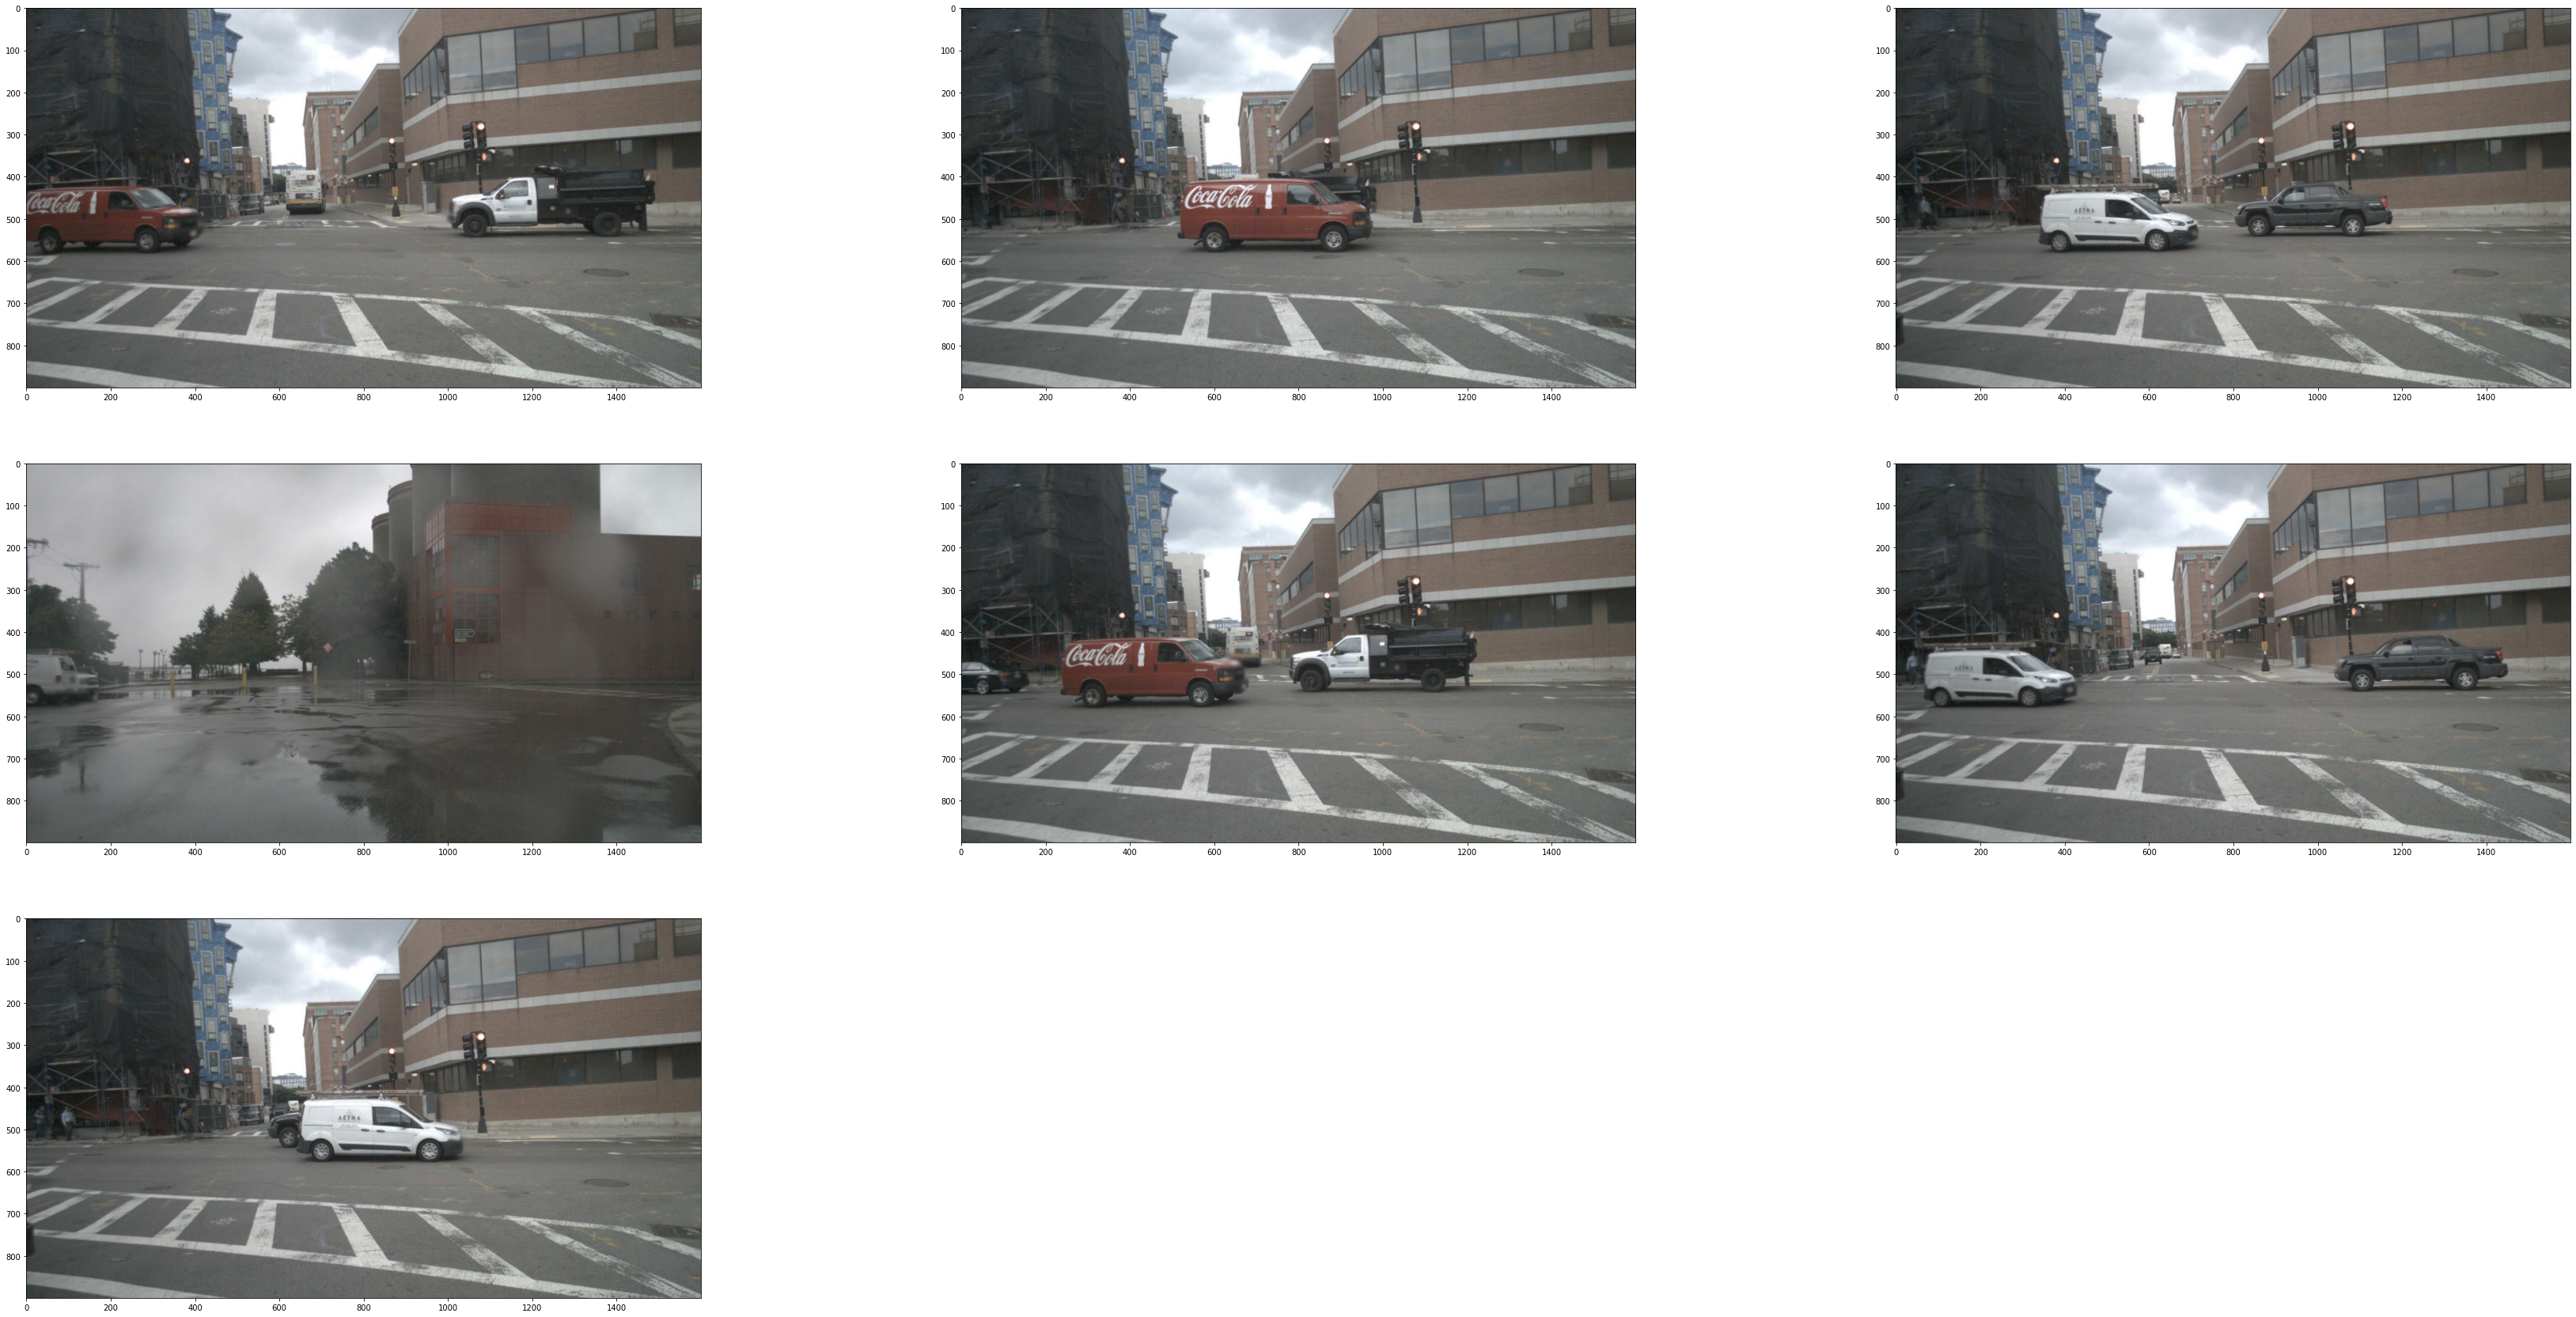

In [15]:
expected_imgs = [
    'n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657118112404.jpg',
    'n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657119112404.jpg',
    'n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657127612404.jpg',
    'n008-2018-09-18-12-07-26-0400__CAM_FRONT__1537287358412404.jpg',
    'n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657118612404.jpg',
    'n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657127112404.jpg',
    'n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657128112404.jpg',
]
show_images(data_dir, expected_imgs, sample=10)

Percentage of expected results missing from query:  7 / 7 = 100.0 %
image n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657118112404.jpg
loaded
image n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657119112404.jpg
loaded
image n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657127612404.jpg
loaded
image n008-2018-09-18-12-07-26-0400__CAM_FRONT__1537287358412404.jpg
loaded
image n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657118612404.jpg
loaded
image n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657127112404.jpg
loaded
image n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657128112404.jpg
loaded


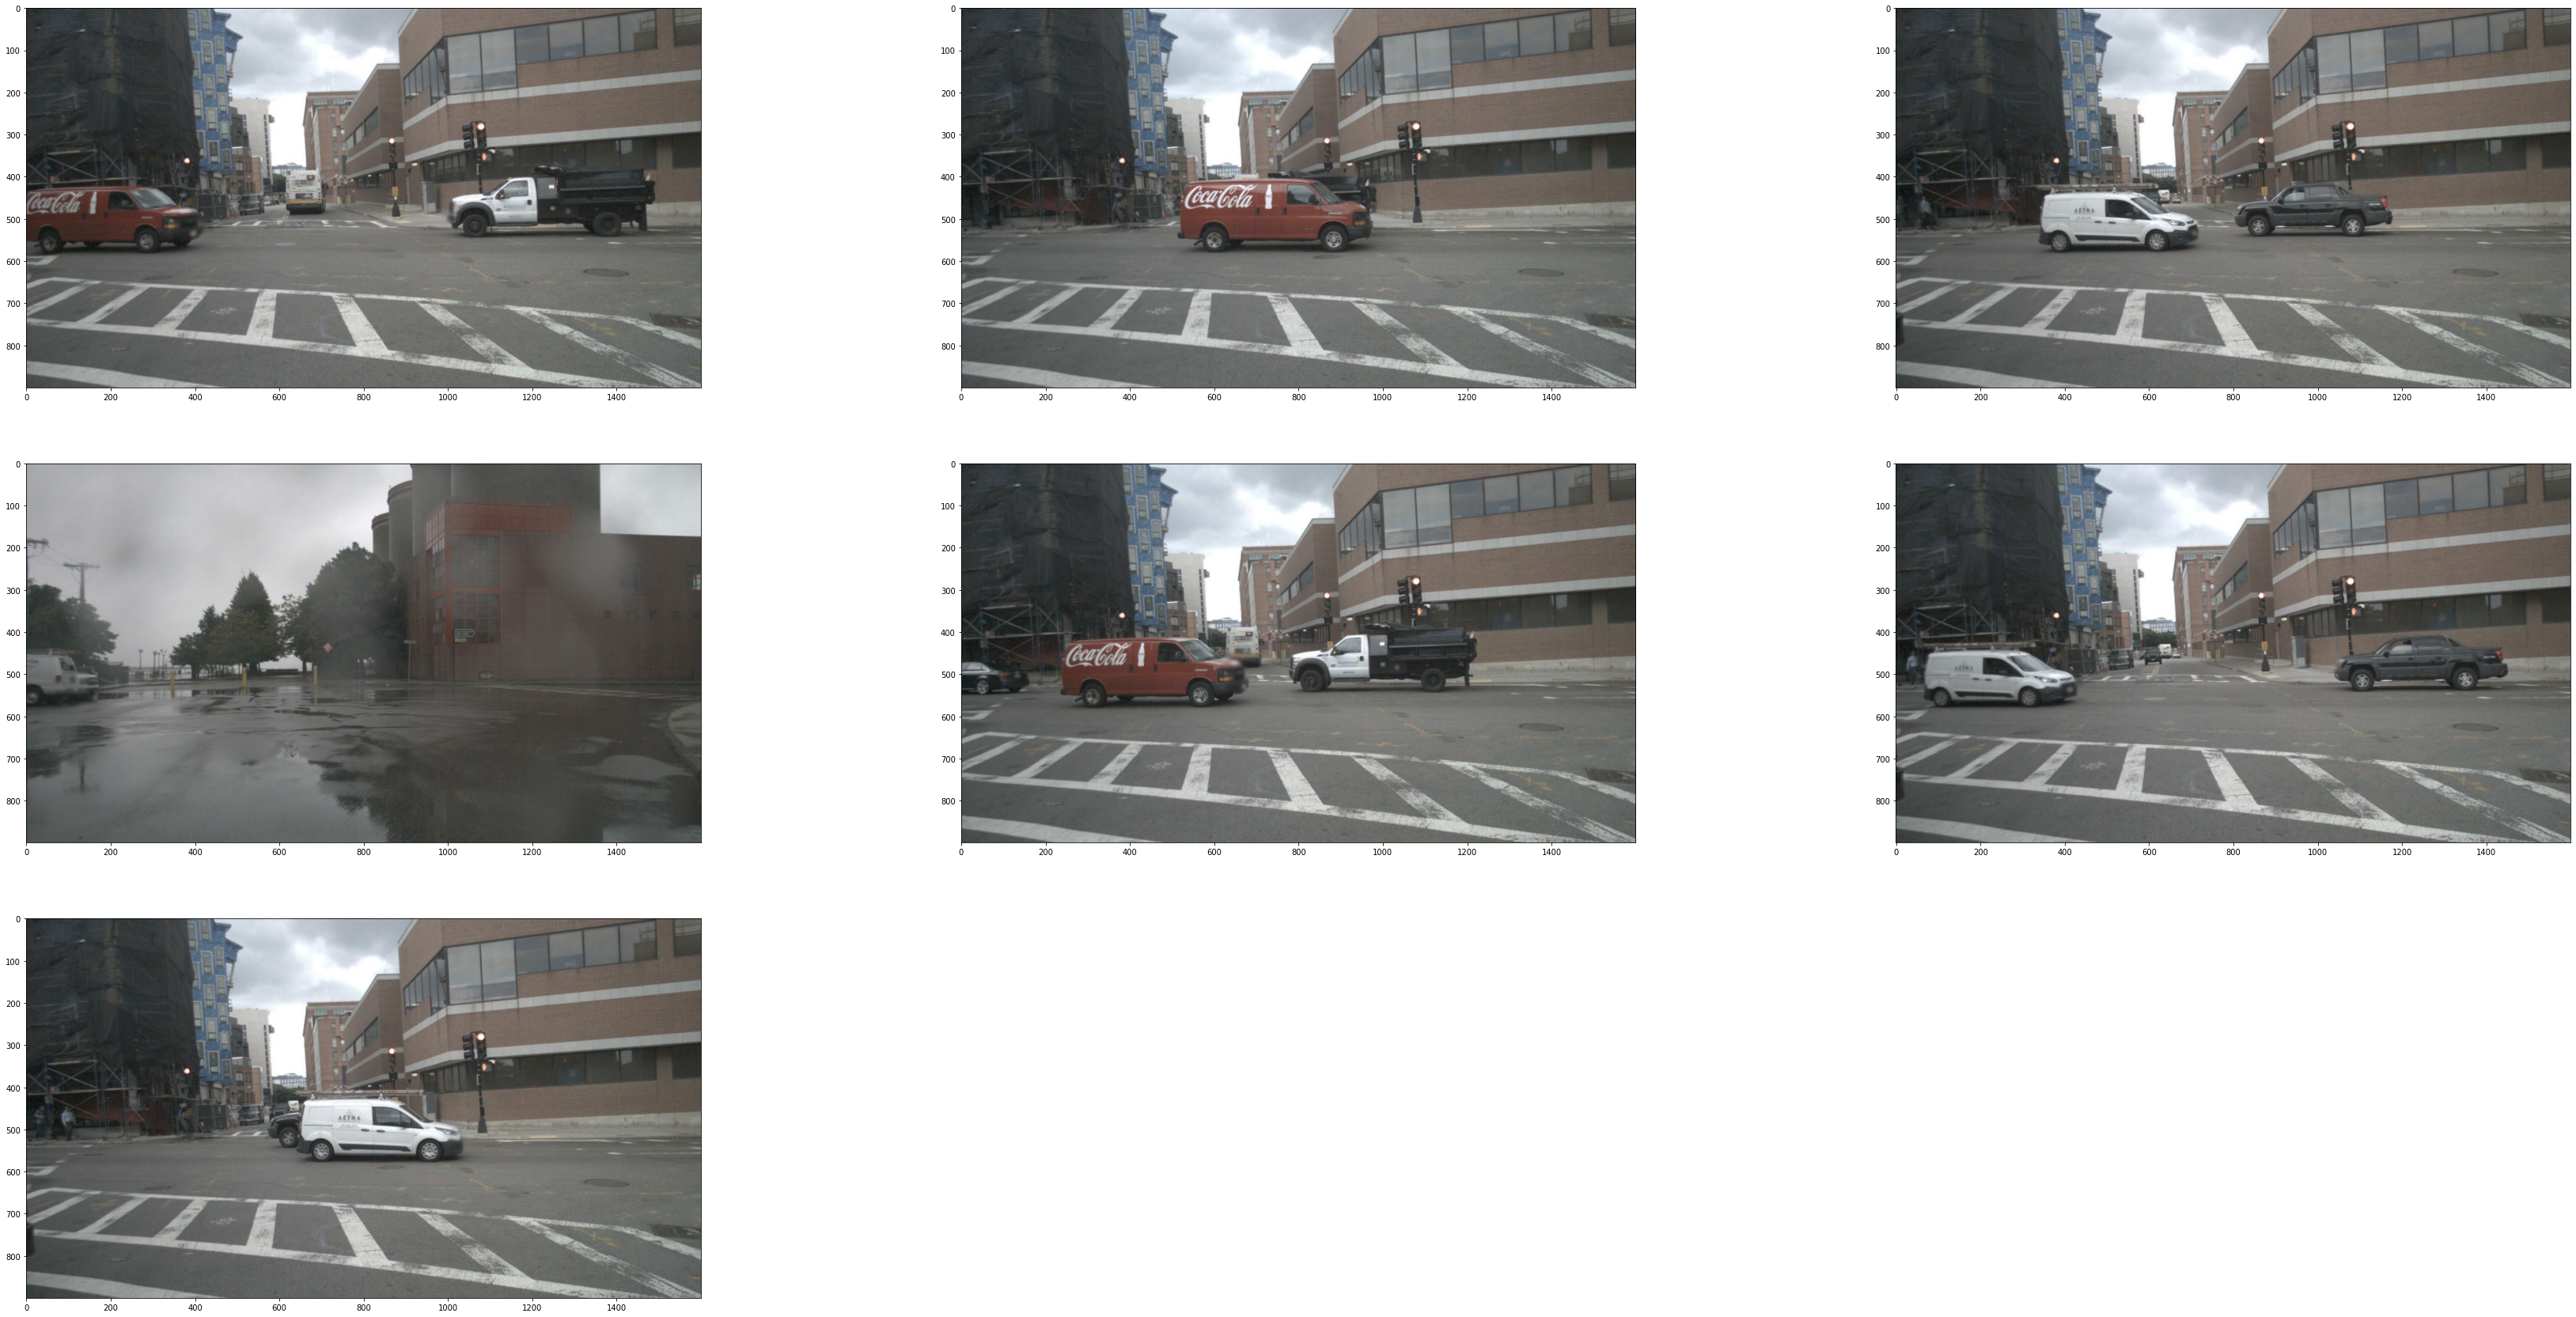

In [16]:
missing = 0
missing_images = []
for expected_img in expected_imgs:
    if expected_img not in resultImages.keys():
        missing += 1
        missing_images.append(expected_img)
print("Percentage of expected results missing from query: ", missing, "/", len(expected_imgs), "=", 100 * missing / len(expected_imgs), "%")
show_images(data_dir, missing_images, sample=10)

In [17]:
extra = 0
extra_images = {}
for img in resultImages.keys():
    if img not in expected_imgs:
        extra += 1
        extra_images[img] = resultImages[img]
print("Percentage of images in query but not in expected results: ", extra, "/", len(resultImages.keys()), "=", 100 * extra / len(resultImages.keys()), "%")
show_images(data_dir, extra_images, sample=10, seed=5)

ZeroDivisionError: division by zero